# 002_Post_Get_Organized
## Project by Tomasz Gusciora
## Visit my website: https://tgusciora.github.io/
## or my Substack: https://demistyfai.substack.com/
## or my Github: https://github.com/TGusciora

In this project I will share some concepts of analytical projects organization for:
* ease of management
* possible automations
* use of standardized folder structure
* future reproducibility


### I. Packages import, notebook options, environment variables

In [2]:
# Import project package, all subpackages and modules
import src

# Load dictionary of project paths
# Crawler from parent directory
paths = src.utils.paths.paths_dictionary()
print("Contents of paths dictionary:")
for key in paths:
    print(key, ": ", paths[key])

# Load environment variables - safe way to load sensitive data
import dotenv
import os
dotenv.load_dotenv(os.path.join(os.path.dirname(os.getcwd()), '.env'))

# Basic packages
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# Pandas and display settings
import pandas as pd
pd.options.display.max_columns = 300
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 250
pd.options.display.float_format = '{:,.2f}'.format

# Clean code & pandas display settings
import black

# Project specific packages
import sklearn as sk
from sklearn import metrics

# FB (Hi Mark) module for forecasting
from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json

Contents of paths dictionary:
data :  /app/data/
docs :  /app/docs/
models :  /app/models/
notebooks :  /app/notebooks/
references :  /app/references/
reports :  /app/reports/
src :  /app/src/
app :  /app/
data_external :  /app/data/external/
data_interim :  /app/data/interim/
data_processed :  /app/data/processed/
data_raw :  /app/data/raw/
reports_figures :  /app/reports/figures/
src_data :  /app/src/data/
src_features :  /app/src/features/
src_models :  /app/src/models/
src_utils :  /app/src/utils/
src_visualization :  /app/src/visualization/


In [3]:
# Enable autoreload - that way you don't have to reload modules, when you change them
# Enable matplotlib inline display
src.utils.start_wrapper.wrapper_notebook_settings()

In [4]:
# Check what versions of packages are you using and save them
!pip freeze > './requirements_snapshot.txt'

In [6]:
# Call the function to generate requirements file with strong specifiers
# Needs: 1) all necessary imports done before that cell
# 2) all necessary packages mentioned in /project_folder/requirements.txt
src.utils.requirements_versions.requirements_versions()

Custom requirements.txt generated successfully at /app/notebooks/requirements_versions.txt


### II. Parameters section
This is where all your modifyable parameters for the notebook should be

In [5]:
# stock name in stooq.com required format
stock = 'aapl.us'  
start_date = '1984-09-07' 
end_date = '2024-03-15'
# Number of days to forecast
forecast_days = 7

# Prophet (Hi Mark) forecast model name
model_name = 'm001_tg_appl'
# Random seed for reproducibility of results in stochastic processes
seed = 123
np.random.seed(seed)

In [6]:
# Kids, don't do this at home
# example of calling environment variable
os.environ['secret_apiKey']

'S0_S3cR3T'

### III. Obtain, save and inspect raw Data

Do not meddle with raw data. This is why kittens end up in hell.

Raw data is there untouched so:
1) You can always reference back to it for checking your data processing quality
2) You can reproduce same analysis in the future and obtain same results (except for some experiments where random seed or stochastic processes are not controlllable, but still)
3) Just don't do it. https://www.youtube.com/watch?v=otCpCn0l4Wo

In [7]:
# Load data from Stooq using user-written function
data_in = src.data.make_dataset.stooqData(stock)

# Save data to csv
data_in.to_csv(paths['data_raw']+stock+'.csv', index=False) 

In [8]:
src.utils.df_inspect.DataFrameInspector(data_in)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9961 entries, 0 to 9960
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    9961 non-null   datetime64[ns]
 1   open    9961 non-null   float64       
 2   high    9961 non-null   float64       
 3   low     9961 non-null   float64       
 4   close   9961 non-null   float64       
 5   volume  9961 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 467.1 KB
None 

First 5 Rows of the DataFrame:
        date  open  high  low  close         volume
0 1984-09-07  0.10  0.10 0.10   0.10  97,676,041.84
1 1984-09-10  0.10  0.10 0.10   0.10  75,812,543.28
2 1984-09-11  0.10  0.10 0.10   0.10 178,770,477.03
3 1984-09-12  0.10  0.10 0.10   0.10 156,171,258.20
4 1984-09-13  0.10  0.10 0.10   0.10 243,230,959.40 

Last 5 Rows of the DataFrame:
           date   open   high    low  close         volume
9956 2024-03-12 173.15 1

In [ ]:
# Checking wheter close price is adjusted for stock splits or not
# Apple had 7:1 stock split in 2014-06-09
data_in[(data_in["date"].dt.year == 2014) & (data_in["date"].dt.month == 6)]

# Close price is adjusted

,date,open,high,low,close,volume
7495,2014-06-02,20.1924,20.2184,19.8275,20.0229,4.139481e+08
7496,2014-06-03,20.0169,20.3430,20.0120,20.3050,3.283111e+08
7497,2014-06-04,20.3021,20.6381,20.2592,20.5383,3.760571e+08
7498,2014-06-05,20.5833,20.6849,20.4675,20.6201,3.404549e+08
7499,2014-06-06,20.7009,20.7427,20.5273,20.5623,3.926505e+08
7500,2014-06-09,20.6699,20.9292,20.4566,20.8892,3.377682e+08
7501,2014-06-10,21.1216,21.1933,20.8614,21.0119,2.813494e+08
7502,2014-06-11,20.9860,21.1276,20.8394,20.9252,2.046828e+08
7503,2014-06-12,20.9630,20.9840,20.4895,20.5783,2.453256e+08
7504,2014-06-13,20.5583,20.6111,20.2612,20.3499,2.444800e+08


### IV. Data manipulation

Each time you download data from Stooq and receive new observations, you want to limit them to set dates for analysis.

Notes: For production purposes this wouldn't be the case as we would probably let our model to absorb new data everyday and correct its predictions based on ground truth (actual data).

In [ ]:
# Limit analysis to set-up dates in parameters
data_in = data_in[(data_in["date"] >= start_date) & (data_in["date"] <= end_date)]


### V. Train and test split

Train - sample on which our forecasting model will train itself  
Test - sample on which we will test quality of our models prediction  
  
Prophet (Hi Mark) requires you to set date variable as 'ds' and variable that we want to predict as 'y'.  
Otherwise it won't work.

In [ ]:
# Train and test split - forecast_days last observations are used as test set

train = data_in[['date', 'close']][:-forecast_days].copy()  
train.columns = ['ds', 'y']
display('train dataset size:', train.shape)

test = data_in[['date', 'close']][-forecast_days:].copy()
test.columns = ['ds', 'y']  
display('train dataset size:', test.shape)

'train dataset size:'

(9940, 2)

'train dataset size:'

(7, 2)

In [ ]:
# last observations of training dataset
train.tail()

,ds,y
9935,2024-02-09,188.85
9936,2024-02-12,187.15
9937,2024-02-13,185.04
9938,2024-02-14,184.15
9939,2024-02-15,183.86


In [ ]:
# our test dataset contents
test

,ds,y
9940,2024-02-16,182.31
9941,2024-02-20,181.56
9942,2024-02-21,182.32
9943,2024-02-22,184.37
9944,2024-02-23,182.52
9945,2024-02-26,181.16
9946,2024-02-27,182.63


### VI. Train model

In [ ]:
m = Prophet()
m.fit(train)

09:13:29 - cmdstanpy - INFO - Chain [1] start processing
09:13:35 - cmdstanpy - INFO - Chain [1] done processing


### VII. Use model to forecast the future

In [ ]:
future = m.make_future_dataframe(periods=2*forecast_days)
future = future[future['ds'].dt.dayofweek < 5] # exclude weekends
future.tail(10)

,ds
9940,2024-02-16
9943,2024-02-19
9944,2024-02-20
9945,2024-02-21
9946,2024-02-22
9947,2024-02-23
9950,2024-02-26
9951,2024-02-27
9952,2024-02-28
9953,2024-02-29


In [ ]:
# Predict the future
forecast = m.predict(future)

# yhat - forecasted value
# yhat_lower - lower bound of forecast (uncertainty interval)
# yhat_upper - upper bound of forecast (uncertainty interval)
# https://facebook.github.io/prophet/docs/uncertainty_intervals.html
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
9945,2024-02-23,184.619277,174.732913,194.688029
9946,2024-02-26,184.689388,174.774515,194.146332
9947,2024-02-27,184.719232,173.993228,195.399914
9948,2024-02-28,184.757523,174.284997,195.334156
9949,2024-02-29,184.731434,174.281392,194.259407


### VII. Evaluate models prediction

In [ ]:
# Compare ground truth y with forecast yhat
test_forecast = test.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')
test_forecast.tail()

,ds,y,yhat,yhat_lower,yhat_upper
2,2024-02-21,182.32,184.734148,174.163135,194.785947
3,2024-02-22,184.37,184.697702,174.296939,195.271296
4,2024-02-23,182.52,184.619277,174.732913,194.688029
5,2024-02-26,181.16,184.689388,174.774515,194.146332
6,2024-02-27,182.63,184.719232,173.993228,195.399914


In [ ]:
full_sample = pd.concat([train, test_forecast], ignore_index=True, sort=False)
full_sample = full_sample[full_sample['y'].notnull()] # remove rows without ground truth

In [ ]:
full_sample.tail(2*forecast_days)

,ds,y,yhat,yhat_lower,yhat_upper
9933,2024-02-07,189.41,NaN,NaN,NaN
9934,2024-02-08,188.32,NaN,NaN,NaN
9935,2024-02-09,188.85,NaN,NaN,NaN
9936,2024-02-12,187.15,NaN,NaN,NaN
9937,2024-02-13,185.04,NaN,NaN,NaN
9938,2024-02-14,184.15,NaN,NaN,NaN
9939,2024-02-15,183.86,NaN,NaN,NaN
9940,2024-02-16,182.31,184.576745,174.357626,194.577092
9941,2024-02-20,181.56,184.701592,174.311113,195.015127
9942,2024-02-21,182.32,184.734148,174.163135,194.785947


In [ ]:
# It seem's that our predition (yhat) is revolving around train dataset's last 3 days average value (y)
np.mean(train['y'][-3:])

184.35

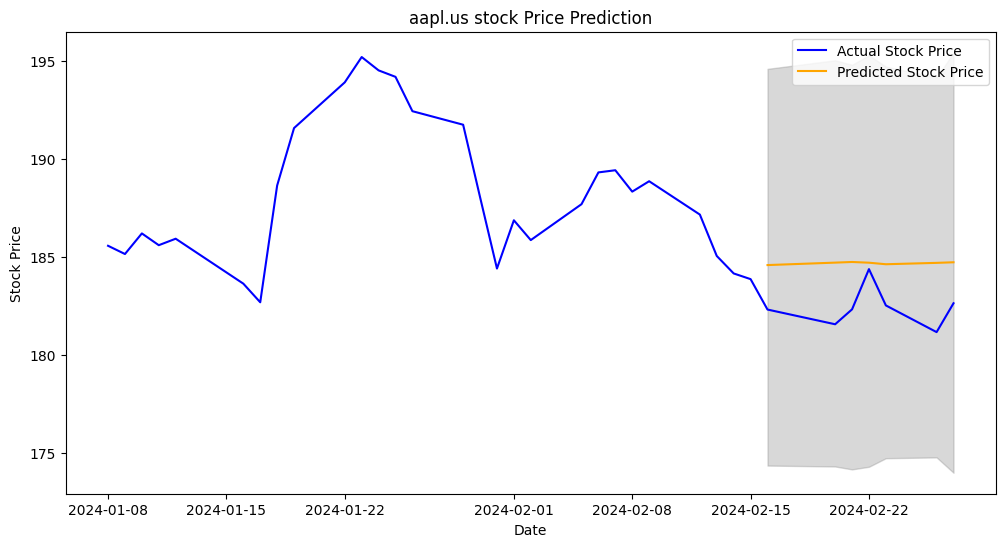

In [ ]:
# Plotting
src.visualization.visualize.prophet_plot_forecast(data = full_sample, title = stock, obs = forecast_days)


Short-term prediction using default model is doesn't really predict price variations but allocates values revolving around latest mean prices.

For prediction purposes - this is not great.
For investment purposes:
* If we would buy a contract that stock price would reach 184,5 USD, we would lose money during prediction period.
* If we would buy APPL stocks on 2024-02-15 for 183,86 USD (let's skip commision for the sake of argument) and sell them 2024-02-22, we would gain 0,51 USD per share. That's 0,28% profit (but in real-life we would have to pay comission twice - that would most probably eat all gains & more).

In [ ]:
# Export full dataset
full_sample.to_csv(paths['data_processed']+'forecast_full_sample.csv', index=False) 

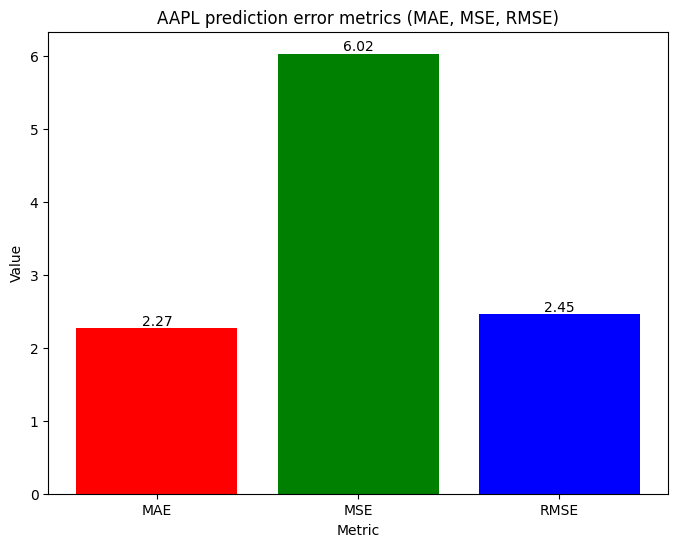

In [ ]:
# Prediction errors
src.visualization.visualize.plot_forecast_error(data = full_sample, title = 'AAPL', path = paths['reports_figures'])

# image of a poor prophet
# bad prophet, bad

### IX. Exporting your model for future use

For Prophet (Hi Mark) there can be problems with pickling -> hence we use serialization
https://facebook.github.io/prophet/docs/serialization.html

In [ ]:
# Python serializing


with open(paths['models'] + model_name + '.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model

In [ ]:
with open(paths['models'] + model_name + '.json', 'r') as fin:
    m_test = model_from_json(fin.read())  # Load model

### X. Check if your re-loaded model predicts same values as the old one

https://github.com/facebook/prophet/issues/1124

Stochasticity comes in the prediction stage, and derives entirely from the trend uncertainty estimation. Increasing uncertainty_samples reduces variance in yhat_upper but it is still stochastic.

np.random.seed() controls randomness in the process.

In [ ]:
# this is not DRY - but why?
# you have to set random seed again before every Prophet preidction - checked empirically
np.random.seed(seed)
forecast_check = m_test.predict(future)

# Assuming df1 and df2 are your DataFrames
import pandas.testing
try:
    pandas.testing.assert_frame_equal(forecast, forecast_check)
    are_completely_same = True
except AssertionError:
    are_completely_same = False
print(f"Are the two DataFrames the same? {are_completely_same}")

# confidence intervals yhat_lower and yhat_uppe would be different if we wouldnt set np.random.seed(seed) to constant value

Are the two DataFrames the same? True


Done! Your model is serialized and ready to use in other projects!

Also:
* you can create similar models by just changing the parameters section
* you can go back at any time to your project and have the same results
* project structure is nice and clear
* you can re-use written modules and functiones in other project without searching for them in the notebook